In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import warnings

warnings.simplefilter(action='ignore')

from src.pathology.core import (compute_roi_tau, compute_roi_amyloid)
from src.pathology.laterality import laterality_index
from src.analysis.misc import set_plot_style
from src.analysis.plots import plot_regression
from src.analysis.surf import plot_surface
from src.connectomics.atlases import (fetch_schaefer_atlas, get_sch_rois)

set_plot_style(dpi=150)

# in
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
df_dir = os.path.join(data_dir, 'datasets')

# out
media_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'media'))

plot_dir = os.path.join(media_dir, '_plots')
surfplot_dir = os.path.join(plot_dir, 'surfs')
os.makedirs(surfplot_dir, exist_ok=True)

### partial volume correction PET

N (xs) = (469, 622)


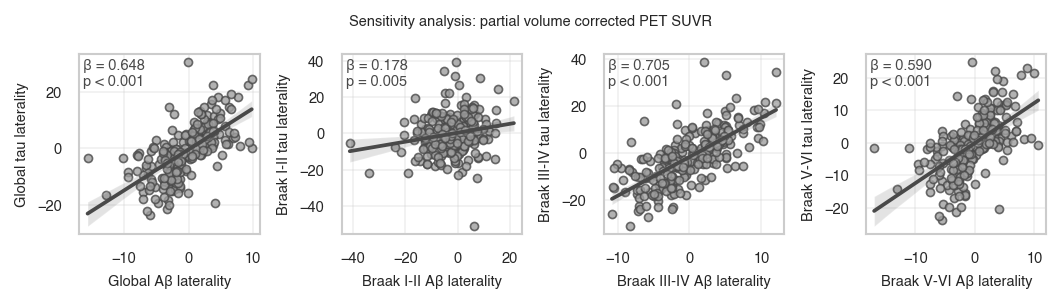

In [2]:
amy_prefix = 'fgc'
tau_prefix = 'tgic'
grp_col = 'temporal_meta_tau_asymmetry_group'
covars = ['age', 'gender_baseline_variable']

df = pd.read_csv(os.path.join(df_dir, f'bf2_tau_asymmetry_ad_t_xs_{tau_prefix}_{amy_prefix}.csv'), low_memory=False, index_col=0)

cols = ['sid', 'mid', grp_col] + covars + [col for col in df.columns if col.startswith((amy_prefix, tau_prefix, 'aparc_ct_'))]
df = df[cols].copy()
print(f"N (xs) = {df.shape}")

### plot config

grp_colors = {'LA': '#5785C1FF', 'LA-S': '#ff6961', 'S': '#D3D4D8FF', 'RA-S': '#ff6961', 'RA': '#FBA72AFF'}
statann_kwargs = dict(fontsize=7, color='#494949')
scatter_kwargs = dict(s=15, lw=0.8, alpha=0.8, edgecolor='#494949', color='#9f9f9f')
legend_kwargs = dict(loc='best', title='Tau asymmetry', title_fontsize=7)
strip_kwargs = dict(linewidth=0.8, size=3, alpha=0.8, edgecolor='#494949')
box_kwargs = dict(alpha=0.95, lw=0.8)
pval_kwargs = dict(lw=0.8, fontsize=7, col='#494949', h_coef=0.015, y_coef=0.1)

label_dict = {f'{tau_prefix}_temporal_meta_LI': 'Temporal tau laterality', f'{tau_prefix}_cho_com_I_II_LI': 'Braak I-II tau laterality', 
              f'{tau_prefix}_cho_com_III_IV_LI': 'Braak III-IV tau laterality', f'{tau_prefix}_cho_com_V_VI_LI': 'Braak V-VI tau laterality', 
              f'{amy_prefix}_temporal_meta_LI': 'Temporal Aβ laterality', f'{amy_prefix}_cho_com_I_II_LI': 'Braak I-II Aβ laterality', 
              f'{amy_prefix}_cho_com_III_IV_LI': 'Braak III-IV Aβ laterality', f'{amy_prefix}_cho_com_V_VI_LI': 'Braak V-VI Aβ laterality',
              f'{tau_prefix}_global_LI': 'Global tau laterality', f'{amy_prefix}_global_LI': 'Global Aβ laterality'}

fig, axs = plt.subplots(1, 4, figsize=(180/25.4, 50/25.4))

# subplot for regression between Ab vs tau lateralities

for i, roi in enumerate(['global_LI', 'cho_com_I_II_LI', 'cho_com_III_IV_LI', 'cho_com_V_VI_LI']):
    y = f'{tau_prefix}_{roi}'
    x = f'{amy_prefix}_{roi}'

    df_ = df.dropna(subset=[x, y])
    

    df_ = df_.loc[abs(df_[x]) <= 50] # one outlier removed with Ab laterality over 50 at Braak I-II
    _, axs[i], model = plot_regression(df=df_, x=x, y=y, covars=['age', 'gender_baseline_variable'], standardise=True,
                                ax=axs[i], xlabel=label_dict[x], ylabel=label_dict[y], 
                                text_kwargs=statann_kwargs, scatter_kwargs=scatter_kwargs)
    # print(model.summary())


plt.suptitle("Sensitivity analysis: partial volume corrected PET SUVR", fontsize=7)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, f'suppl_sens_partialvolcor_xs_laterality.pdf'), format='pdf', dpi=300)
plt.show()

### CBF & CT

CBF vs Ab n=53
CBF vs tau n=101
Ab vs tau adj CBF n=53
CT vs Ab n=231
CT vs tau n=449
Ab vs tau adj CT n=231


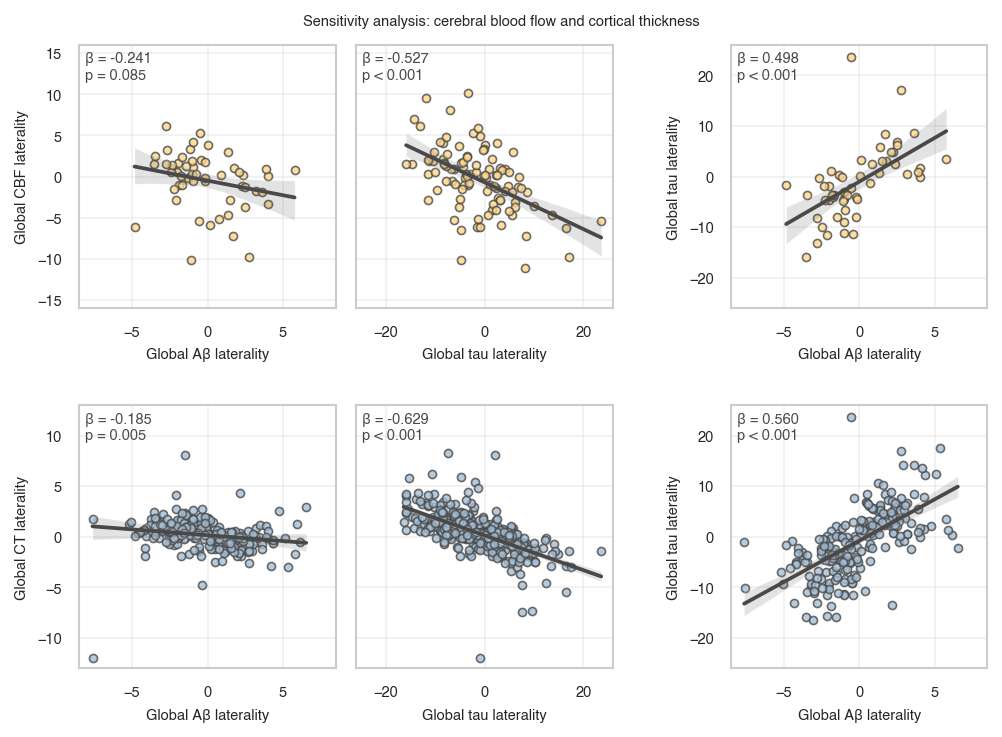

In [3]:
### ASL data

df_asl = pd.read_excel(os.path.join(data_dir, 'asl', 'mean_CBF_QCed_HOatlasROIs.xlsx')).rename(columns={'SUBJECT':'mid'})

csf_cols_L = [col for col in df_asl.columns if col.endswith('_L')]
csf_cols_R = [col for col in df_asl.columns if col.endswith('_R')]

df_asl['CBF_global_L'] = df_asl[csf_cols_L].mean(axis=1)
df_asl['CBF_global_R'] = df_asl[csf_cols_R].mean(axis=1)

df_asl = df_asl[['mid', 'CBF_global_L', 'CBF_global_R']]

df_asl['CBF_global_LI'] = df_asl.apply(lambda row: laterality_index(
    row['CBF_global_L'], row['CBF_global_R']), axis=1)

### BF2 data

amy_prefix = 'fnc'
tau_prefix = 'tnic'

df_bf2 = pd.read_csv(os.path.join(df_dir, f'bf2_tau_asymmetry_ad_t_xs_{tau_prefix}_{amy_prefix}.csv'), low_memory=False, index_col=0)
df_bf2_asl = df_bf2.dropna(subset='has_ASL')

grp_col = 'temporal_meta_tau_asymmetry_group'

# df_bf2 = df_bf2[df_bf2[grp_col].isin(['LA',  'S', 'RA'])]
# df_bf2[grp_col] = pd.Categorical(df_bf2[grp_col], categories=['LA',  'S',  'RA'], ordered=True)

### merge

df = pd.merge(df_bf2_asl, df_asl, on='mid', how='inner')

### plotting

set_plot_style(dpi=150)
statann_kwargs = dict(fontsize=7, color='#494949')
# scatter_kwargs = dict(s=15, lw=0.8, alpha=0.8, edgecolor='#494949', color='#9f9f9f')

tau_minmax = [-26, 26]
amy_minmax = [-8.5, 8.5]

fig, axs = plt.subplots(2, 4, figsize=(170/25.4, 125/25.4), gridspec_kw={'width_ratios': [1, 1, 0.3, 1]})

## CBF

cbf_minmax = [-16, 16]
cbf_scatter_kwargs = dict(s=15, lw=0.8, alpha=0.8, edgecolor='#494949', color='#FED789FF')

df_ = df.dropna(subset=['fnc_global_LI'])
print(f'CBF vs Ab n={df_.shape[0]}')
_, axs[0,0], mdl_amy = plot_regression(ax=axs[0,0], df=df_, x=f'fnc_global_LI', y='CBF_global_LI', 
                                     covars=['age', 'gender_baseline_variable'], standardise=True,
                                     xlabel='Global Aβ laterality', ylabel='Global CBF laterality',
                                     text_kwargs=statann_kwargs, scatter_kwargs=cbf_scatter_kwargs)
axs[0,0].set_xlim(amy_minmax), axs[0,0].set_ylim(cbf_minmax)
# axs[0,0].set_title(f'OLS (n={len(df_)}): CBF LI ~ age + sex + Aβ LI')

df_ = df.dropna(subset=['tnic_global_LI'])
print(f'CBF vs tau n={df_.shape[0]}')
_, axs[0,1], mdl_tau = plot_regression(ax=axs[0,1], df=df_, x=f'tnic_global_LI', y='CBF_global_LI', 
                                     covars=['age', 'gender_baseline_variable'], standardise=True,
                                     xlabel='Global tau laterality', ylabel='Global CBF laterality',
                                     text_kwargs=statann_kwargs, scatter_kwargs=cbf_scatter_kwargs)
axs[0,1].set_xlim(tau_minmax), axs[0,1].set_ylim(cbf_minmax)
axs[0,1].set_yticklabels(''), axs[0,1].set_ylabel('')
# axs[0,1].set_title(f'OLS (n={len(df_)}): CBF LI ~ age + sex + tau LI')

axs[0, 2].axis('off')

df_ = df.dropna(subset=['fnc_global_LI', 'tnic_global_LI', 'CBF_global_LI'])
print(f'Ab vs tau adj CBF n={df_.shape[0]}')
_, axs[0,3], model = plot_regression(ax=axs[0,3], df=df_, x='fnc_global_LI', y='tnic_global_LI', 
                              covars=['age', 'gender_baseline_variable', 'CBF_global_LI'], standardise=True,
                              xlabel='Global Aβ laterality', ylabel='Global tau laterality',
                              text_kwargs=statann_kwargs, scatter_kwargs=cbf_scatter_kwargs)
axs[0,3].set_xlim(amy_minmax), axs[0,3].set_ylim(tau_minmax)
# axs[0,3].set_title(f'OLS (n={len(df_)}): tau LI ~ age + sex + CBF LI + Aβ LI')

## CT

ct_minmax = [-13, 13]
ct_scatter_kwargs = dict(s=15, lw=0.8, alpha=0.8, edgecolor='#494949', color='#A4BED5FF')

df_ct = df_bf2.dropna(subset=['fnc_global_LI', 'aparc_ct_global_LI'])
print(f'CT vs Ab n={df_ct.shape[0]}')
_, axs[1,0], model = plot_regression(ax=axs[1,0], df=df_ct, x='fnc_global_LI', y='aparc_ct_global_LI', 
                              covars=['age', 'gender_baseline_variable'], standardise=True,
                              xlabel='Global Aβ laterality', ylabel='Global CT laterality',
                              text_kwargs=statann_kwargs, scatter_kwargs=ct_scatter_kwargs)
axs[1,0].set_xlim(amy_minmax), axs[1,0].set_ylim(ct_minmax)
# axs[1,0].set_title(f'OLS (n={len(df_ct)}): CT LI ~ age + sex + Aβ LI')

df_ct = df_bf2.dropna(subset=['tnic_global_LI', 'aparc_ct_global_LI'])
print(f'CT vs tau n={df_ct.shape[0]}')
_, axs[1,1], model = plot_regression(ax=axs[1,1], df=df_ct, x='tnic_global_LI', y='aparc_ct_global_LI', 
                              covars=['age', 'gender_baseline_variable'], standardise=True,
                              xlabel='Global tau laterality', ylabel='Global CT laterality',
                              text_kwargs=statann_kwargs, scatter_kwargs=ct_scatter_kwargs)
axs[1,1].set_xlim(tau_minmax), axs[1,1].set_ylim(ct_minmax)
axs[1,1].set_yticklabels(''), axs[1,1].set_ylabel('')
# axs[1,1].set_title(f'OLS (n={len(df_ct)}): CT LI ~ age + sex + tau LI')

axs[1, 2].axis('off')

df_ct = df_bf2.dropna(subset=['fnc_global_LI', 'tnic_global_LI', 'aparc_ct_global_LI'])
print(f'Ab vs tau adj CT n={df_ct.shape[0]}')
_, axs[1,3], model = plot_regression(ax=axs[1,3], df=df_ct, x='fnc_global_LI', y='tnic_global_LI', 
                              covars=['age', 'gender_baseline_variable', 'aparc_ct_global_LI'], standardise=True,
                              xlabel='Global Aβ laterality', ylabel='Global tau laterality',
                              text_kwargs=statann_kwargs, scatter_kwargs=ct_scatter_kwargs)
axs[1,3].set_xlim(amy_minmax), axs[1,3].set_ylim(tau_minmax)
# axs[1,3].set_title(f'OLS (n={len(df_ct)}): tau LI ~ age + sex + CT LI + Aβ LI')

plt.suptitle("Sensitivity analysis: cerebral blood flow and cortical thickness", fontsize=7)
plt.tight_layout(w_pad=-3, h_pad=3)
plt.savefig(os.path.join(plot_dir, f'suppl_sens_CBF_CT_ab_tau_LI_global.pdf'), format='pdf', dpi=300)
plt.show()